In [20]:
from dataloader import *
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [21]:
train, test = get_train_test(5, 0)

In [30]:
m =MinMaxScaler()
np.var(m.fit_transform(train[:, , :, :].reshape(-1, 24)))


0.0027819086219529341

In [4]:
var_agg = np.var(train[:, 0, :, :])
var_agg

993454.05801923585

In [5]:
def reduction_variance(split_appliance="hvac"):
    index_appliance = APPLIANCE_ORDER.index(split_appliance)
    var_appliance = np.var(train[:, index_appliance, :, :])
    var_agg_min_appliance = np.var(train[:, 0, :, :] - train[:, index_appliance, :, :])

    return var_agg - (var_appliance+var_agg_min_appliance)

In [8]:
pd.Series({appliance:reduction_variance(appliance) for appliance in APPLIANCE_ORDER[1:]}).sort_values()

mw         5485.874936
dw        17192.616183
fridge    17618.636000
dr        72969.938412
hvac      96338.519423
dtype: float64

In [10]:
APPLIANCE_ORDER

['aggregate', 'hvac', 'fridge', 'dr', 'dw', 'mw']

In [14]:
%matplotlib inline

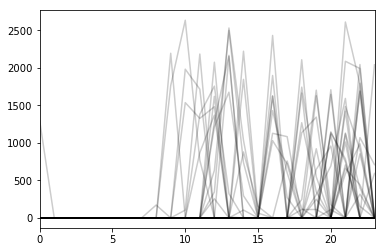

In [17]:
pd.DataFrame(train[0,3, :, : ]).T.plot(color='k',alpha=0.2, legend=False)

In [19]:
pd.DataFrame(train[0,3, :, : ]).describe()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
count,112.000000,112.0,112.0,112.0,112.0,112.000000,112.0,112.000000,112.000000,112.000000,...,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000
mean,11.551339,0.0,0.0,0.0,0.0,0.001042,0.0,0.001190,1.532440,35.347620,...,63.566816,1.955208,99.723066,30.770834,74.980802,69.833780,77.604762,142.445090,144.012054,29.921578
std,122.236758,0.0,0.0,0.0,0.0,0.011024,0.0,0.008868,16.205118,264.906505,...,305.793251,15.730308,403.434935,152.947187,336.984295,279.476493,303.851513,442.042217,446.038272,210.600646
min,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1293.633301,0.0,0.0,0.0,0.0,0.116667,0.0,0.066667,171.500000,2194.916748,...,2222.000000,153.883331,2432.350098,1083.266724,2107.899902,1702.949951,1708.300049,2611.383301,2044.433350,2041.466675


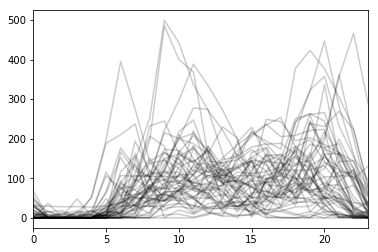

In [58]:
pd.DataFrame(train[:,3, :, : ].mean(axis=1)).T.plot(color='k',alpha=0.2,legend=False)

In [61]:
d = train[:,3, :, : ]

In [63]:
z, x, y = d.nonzero()

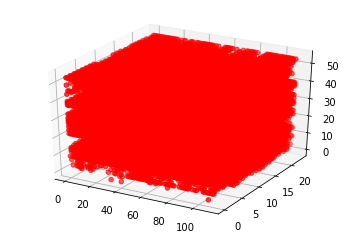

In [66]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, zdir='z', c= 'red')

In [75]:
import sys
import numpy as np
import pandas as pd
from dataloader import APPLIANCE_ORDER, get_train_test
from tensor_custom_core import stf_4dim, stf_4dim_time
import torch
import torch.nn as nn
from torch.autograd import Variable
torch.manual_seed(0)
np.random.seed(0)


class CustomRNN(nn.Module):
    def __init__(self, cell_type, hidden_size, num_layers, bidirectional):
        super(CustomRNN, self).__init__()
        torch.manual_seed(0)

        if bidirectional:
            self.num_directions = 2
        else:
            self.num_directions = 1
        if cell_type=="RNN":
            self.rnn = nn.RNN(input_size=1, hidden_size=hidden_size,
                   num_layers=num_layers, batch_first=True,
                   bidirectional=bidirectional)
        elif cell_type=="GRU":
            self.rnn = nn.GRU(input_size=1, hidden_size=hidden_size,
                              num_layers=num_layers, batch_first=True,
                              bidirectional=bidirectional)
        else:
            self.rnn = nn.LSTM(input_size=1, hidden_size=hidden_size,
                              num_layers=num_layers, batch_first=True,
                              bidirectional=bidirectional)

        self.linear = nn.Linear(hidden_size*self.num_directions, 1 )
        self.linear2 = nn.Linear(24 * 2, 24)
        self.act = nn.ReLU()

    def forward(self, x, m):
        pred, hidden = self.rnn(x, None)
        print(pred.size())
        pred = self.linear(pred)
        print(pred.size())
        m = m.expand_as(pred)
        print(pred.size(), x.size(), m.size())
        z = torch.cat([pred, m], dim=1).view(-1, 48)
        print(z.size())
        print(self.linear2)
        pred = self.linear2(z)
        pred = self.act(pred)
        pred = torch.min(pred, x).view(pred.data.shape[0], -1, 1)
        return pred


num_folds = 5

if torch.cuda.is_available():
    cuda_av = True
else:
    cuda_av=False

gts = []
preds = []

def disagg_fold(fold_num, appliance, cell_type, hidden_size,
                num_layers, bidirectional, lr,
                num_iterations):
    torch.manual_seed(0)

    appliance_num = APPLIANCE_ORDER.index(appliance)
    train, test = get_train_test(num_folds=num_folds, fold_num=fold_num)
    train_aggregate = train[:, 0, :, :].reshape(-1, 24, 1)
    test_aggregate = test[:, 0, :, :].reshape(-1, 24, 1)

    train_appliance = train[:, appliance_num, :, :].reshape(-1, 24, 1)
    test_appliance = test[:, appliance_num, :, :].reshape(-1, 24, 1)
    gts.append(test_appliance.reshape(-1, 24))
    loss_func = nn.L1Loss()
    r = CustomRNN(cell_type, hidden_size, num_layers, bidirectional)

    if cuda_av:
        r = r.cuda()
        loss_func = loss_func.cuda()
    print(r)

    # Setting the params all to be non-negative
    #for param in r.parameters():
    #    param.data = param.data.abs()

    optimizer = torch.optim.Adam(r.parameters(), lr=lr)

    for t in range(num_iterations):

        inp = Variable(torch.Tensor(train_aggregate), requires_grad=True)
        train_y = Variable(torch.Tensor(train_appliance))
        train_y_mean = train_y.mean(dim=0)
        print(train_y_mean.size())
        if cuda_av:
            inp = inp.cuda()
            train_y = train_y.cuda()
            train_y_mean = train_y_mean.cuda()
        pred = r(inp, train_y_mean)

        optimizer.zero_grad()
        loss = loss_func(pred, train_y)
        if t % 5 == 0:
            print(t, loss.data[0])
        loss.backward()
        optimizer.step()

    test_inp = Variable(torch.Tensor(test_aggregate), requires_grad=False)
    test_y = Variable(torch.Tensor(test_appliance), requires_grad=False)
    if cuda_av:
        test_inp = test_inp.cuda()
    pred = r(test_inp, train_y_mean)
    #pred[pred<0.] = 0.
    pred = torch.clamp(pred, min=0.)
    if cuda_av:
        prediction_fold = pred.cpu().data.numpy()
    else:
        prediction_fold = pred.data.numpy()
    return prediction_fold, test_appliance

def disagg(appliance, cell_type, hidden_size, num_layers, bidirectional, lr, num_iterations):
    from sklearn.metrics import mean_absolute_error
    preds = []
    gts = []
    for cur_fold in range(num_folds):
        pred, gt = disagg_fold(cur_fold, appliance, cell_type, hidden_size, num_folds
                               ,bidirectional, lr, num_iterations)

        preds.append(pred)
        gts.append(gt)
    return mean_absolute_error(np.concatenate(gts).flatten(), np.concatenate(preds).flatten())

appliance = "hvac"
cell_type="GRU" # One of GRU, LSTM, RNN
hidden_size=100 # [20, 50, 100, 150]
num_layers=1  # [1, 2, 3, 4]
bidirectional=False # True or False
lr =1 # 1e-3, 1e-2, 1e-1, 1, 2
num_iterations = 20 #200, 400, 600, 800

In [77]:
p = disagg(appliance, cell_type, hidden_size, num_layers,
                bidirectional, lr, 5)

CustomRNN (
  (rnn): GRU(1, 100, num_layers=5, batch_first=True)
  (linear): Linear (100 -> 1)
  (linear2): Linear (48 -> 24)
  (act): ReLU ()
)
torch.Size([24, 1])
torch.Size([6048, 24, 100])
torch.Size([6048, 24, 1])
torch.Size([6048, 24, 1]) torch.Size([6048, 24, 1]) torch.Size([6048, 24, 1])
torch.Size([6048, 48])
Linear (48 -> 24)
0 823.8992309570312


/Users/nipun/anaconda3/lib/python3.6/site-packages/torch/autograd/_functions/pointwise.py:312: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  ctx._mask = a.lt(b).type_as(a)
/Users/nipun/anaconda3/lib/python3.6/site-packages/torch/autograd/_functions/pointwise.py:313: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return a.min(b)


torch.Size([24, 1])
torch.Size([6048, 24, 100])
torch.Size([6048, 24, 1])
torch.Size([6048, 24, 1]) torch.Size([6048, 24, 1]) torch.Size([6048, 24, 1])
torch.Size([6048, 48])
Linear (48 -> 24)
torch.Size([24, 1])
torch.Size([6048, 24, 100])
torch.Size([6048, 24, 1])
torch.Size([6048, 24, 1]) torch.Size([6048, 24, 1]) torch.Size([6048, 24, 1])
torch.Size([6048, 48])
Linear (48 -> 24)
torch.Size([24, 1])
torch.Size([6048, 24, 100])
torch.Size([6048, 24, 1])
torch.Size([6048, 24, 1]) torch.Size([6048, 24, 1]) torch.Size([6048, 24, 1])
torch.Size([6048, 48])
Linear (48 -> 24)
torch.Size([24, 1])
torch.Size([6048, 24, 100])
torch.Size([6048, 24, 1])
torch.Size([6048, 24, 1]) torch.Size([6048, 24, 1]) torch.Size([6048, 24, 1])
torch.Size([6048, 48])
Linear (48 -> 24)
torch.Size([1568, 24, 100])
torch.Size([1568, 24, 1])
torch.Size([1568, 24, 1]) torch.Size([1568, 24, 1]) torch.Size([1568, 24, 1])
torch.Size([1568, 48])
Linear (48 -> 24)
CustomRNN (
  (rnn): GRU(1, 100, num_layers=5, batch_fi